In [1]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
classes=('BEANS', 'CAKE', 'CANDY', 'CEREAL', 'CHIPS', 'CHOCOLATE', 'COFFEE', 'CORN', 'FISH', 'FLOUR')
trainset = torchvision.datasets.ImageFolder('C:/Users/Mayank/Downloads/projectimages',transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)


In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 2000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [4]:
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=val_sampler, num_workers=2)

CEREAL CHOCOLATE CHIPS  FISH


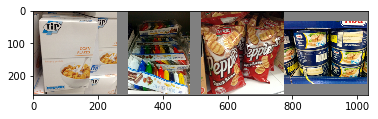

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 128 * 128, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 128 *128)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [7]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

In [8]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

In [9]:
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=val_sampler, num_workers=2)

In [10]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [13]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
       # total_val_loss = 0
        #for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
         #   inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
          #  val_outputs = net(inputs)
           # val_loss_size = loss(val_outputs, labels)
            #total_val_loss += val_loss_size.data[0]
            
       # print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [21]:
CNN = SimpleCNN()
trainNet(CNN, batch_size=32, n_epochs=5, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 5
learning_rate= 0.001


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 11% 	 train_loss: 16.19 took: 16.31s
Epoch 1, 22% 	 train_loss: 4.49 took: 13.88s
Epoch 1, 33% 	 train_loss: 2.92 took: 14.27s
Epoch 1, 44% 	 train_loss: 2.67 took: 13.10s
Epoch 1, 55% 	 train_loss: 2.70 took: 13.52s
Epoch 1, 66% 	 train_loss: 2.69 took: 13.85s
Epoch 1, 77% 	 train_loss: 2.69 took: 13.87s
Epoch 1, 88% 	 train_loss: 2.67 took: 14.21s
Epoch 1, 100% 	 train_loss: 2.66 took: 13.61s
Epoch 2, 11% 	 train_loss: 2.61 took: 15.90s
Epoch 2, 22% 	 train_loss: 2.55 took: 13.18s
Epoch 2, 33% 	 train_loss: 2.57 took: 13.27s
Epoch 2, 44% 	 train_loss: 2.53 took: 13.84s
Epoch 2, 55% 	 train_loss: 2.60 took: 13.77s
Epoch 2, 66% 	 train_loss: 2.51 took: 13.30s
Epoch 2, 77% 	 train_loss: 2.53 took: 13.14s
Epoch 2, 88% 	 train_loss: 2.48 took: 13.12s
Epoch 2, 100% 	 train_loss: 2.54 took: 11.77s
Epoch 3, 11% 	 train_loss: 2.46 took: 15.32s
Epoch 3, 22% 	 train_loss: 2.47 took: 13.11s
Epoch 3, 33% 	 train_loss: 2.52 took: 13.27s
Epoch 3, 44% 	 train_loss: 2.48 took: 13.12s
Epoch 3

GroundTruth:   FISH CANDY CEREAL CANDY


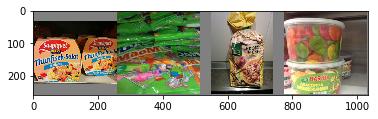

In [16]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputss=CNN(images)

In [19]:
_, predicted = torch.max(outputss, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  CHOCOLATE CANDY CEREAL CANDY
